# CLIP Classification

In this notebook, we'll be using CLIP for zero-shot classification on the CIFAR-10 dataset. Zero-shot classification is a technique where a model classifies data that it's never seen examples of during training. As such, it must rely on the quality of the classifications and its ability to generalize.

Make sure you're running with GPU runtime:
- Select "GPU" as the hardware accelerator in Runtime > Change Runtime Type

In [1]:
! pip install tqdm git+https://github.com/openai/CLIP.git

import matplotlib.pyplot as plt
import numpy as np
import torch
import clip
from tqdm.notebook import tqdm
import os
from torchvision.datasets import CIFAR10
from torchvision import transforms

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-zmhwjd56
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-zmhwjd56
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.5 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369489 sha256=74ee361ac4809b82e10d47a3261ae9ba1b6053d3ebcba7ab88d12f20255fa002
  Stored in directory: /tmp/pip-ephem-wheel-cache-wbawhayo/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


# Loading the model

Download and instantiate a CLIP model using the `clip` module that we just installed.

In [2]:
# Load in a ViT CLIP model
model, preprocess = clip.load("ViT-B/32")

100%|███████████████████████████████████████| 338M/338M [00:06<00:00, 55.8MiB/s]


# Loading the Cifar-10 Dataset

In [3]:
# Load in CIFAR-10 dataset
cifar10 = CIFAR10(root=os.path.expanduser("~/.cache"), download=True, train=False, transform=preprocess)
loader = torch.utils.data.DataLoader(cifar10, batch_size=32, shuffle=False)

100%|██████████| 170M/170M [00:05<00:00, 28.9MB/s]


Extracting /root/.cache/cifar-10-python.tar.gz to /root/.cache


The following code defines the CIFAR-10 templates and classes, to capture possible language augmentations for image descriptions.

In [4]:
# Define CIFAR-10 templates and classes, to capture possible language augmentations for image descriptions
cifar10_templates = [
    'a photo of a {}.',
    'a blurry photo of a {}.',
    'a black and white photo of a {}.',
    'a low contrast photo of a {}.',
    'a high contrast photo of a {}.',
    'a bad photo of a {}.',
    'a good photo of a {}.',
    'a photo of a small {}.',
    'a photo of a big {}.',
    'a photo of the {}.',
    'a blurry photo of the {}.',
    'a black and white photo of the {}.',
    'a low contrast photo of the {}.',
    'a high contrast photo of the {}.',
    'a bad photo of the {}.',
    'a good photo of the {}.',
    'a photo of the small {}.',
    'a photo of the big {}.',
]

cifar10_classes = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck',
]

# Creating zero-shot classifier weights

Our goal is to generate zero-shot classification weights for the list of CIFAR-10 classes using text templates and the CLIP model. These weights can be used for zero-shot classification tasks where you want to classify images or other data into one of the specified classes, even if the model hasn’t been explicitly trained on those classes.


1. In the zeroshot_classifier function, the code iterates through each class name in the provided class_names list (e.g., 'airplane,' 'automobile,' etc.)
2. For each class name, it uses the templates to create formatted textual descriptions.
3. These formatted texts are tokenized and converted to embeddings using the CLIP model's text encoder, then normalized to ensure consistent scale.
4. The embeddings for each description are averaged to create a representative embedding for the class, and this average embedding is again normalized.
5. The code collects all these embeddings and stacks them into a tensor, resulting in a matrix where each column corresponds to the averaged, normalized embeddings for a specific class.


In [5]:
def zeroshot_classifier(class_names, templates):
    """
    Generates zero-shot classification weights by averaging the embedded templates of class names.

    Parameters:
    class_names (list): A list of names of the classes.
    templates (list): A list of templates to be used in the formatting of class names.

    Returns:
    Tensor: A tensor containing the zero-shot classification weights.
    """
    with torch.no_grad():
        classification_weights = []
        for class_name in class_names:
            formatted_texts = [template.format(class_name) for template in templates]
            tokenized_texts = clip.tokenize(formatted_texts).cuda()

            # TODO: Get embeddings using the CLIP model's text encoder and normalize
            class_embeddings = model.encode_text(tokenized_texts)
            class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)

            # TODO: Average the embeddings and normalize again
            average_embedding = class_embeddings.mean(dim=0)
            average_embedding /= average_embedding.norm()

            # Store the averaged and normalized embedding
            classification_weights.append(average_embedding)

        classification_weights = torch.stack(classification_weights, dim=1).cuda()

    return classification_weights

zeroshot_weights = zeroshot_classifier(cifar10_classes, cifar10_templates)

# Zero-shot prediction

We’re now going to calculate the accuracy of a model's predictions, specifically for the top-k predictions. It's common to measure the accuracy of not just the top-1 prediction (the most confident prediction) but also the top-k predictions (the k most confident predictions), to see if the model is generally leaning toward predicting the right class, just maybe not with the highest certainty.

Here’s how it works:
* Identifies the top-k predictions by selecting the indices of the k highest values in the predictions tensor.
* Compares these top-k predictions with the ground truth labels to check if they are correct. The results are stored in the correct_comparisons tensor.
* For each topk, it calculates the number of correct predictions in the top-k predictions.
* The number of correct predictions for each k is returned


In [6]:
def accuracy(predictions, targets, topk=(1,)):
    """
    Calculate the accuracy of the top k predictions

    Parameters:
    predictions (Tensor): The model output.
    targets (Tensor): Ground truth labels.
    topk (tuple, optional): Tuple indicating the top k predictions to consider for accuracy.

    Returns:
    list: A list of accuracies for each k in topk.
    """

    # Get the top k predictions and their indices
    top_k_preds_indices = predictions.topk(max(topk), dim=1, largest=True, sorted=True)[1].t()

    # Compare the top k predictions with the targets to see if they are correct
    correct_comparisons = top_k_preds_indices.eq(targets.view(1, -1).expand_as(top_k_preds_indices))

    accuracies = []
    for k in topk:
        # Get the number of correct predictions in the top k
        correct_in_top_k = correct_comparisons[:k].reshape(-1).float().sum(0, keepdim=True)

        # Move the correct count to cpu, convert to numpy and then to native Python float
        accuracies.append(float(correct_in_top_k.cpu().numpy()))

    return accuracies

In [7]:
def visualize_predictions(images, actual_labels, predicted_labels, class_names, num_samples=1):
    mu, sigma = torch.tensor((0.48145466, 0.4578275, 0.40821073)), torch.tensor((0.26862954, 0.26130258, 0.27577711))
    mu_, sigma_ = -mu / sigma, 1 / sigma
    images = transforms.Normalize(mu_, sigma_)(images)
    for i in range(num_samples):
        plt.figure(figsize=(4, 4))
        plt.imshow(np.transpose(images[i].cpu().numpy(), (1, 2, 0)))
        plt.title(f"Actual: {class_names[actual_labels[i]]}\nPredicted: {class_names[predicted_labels[i]]}")
        plt.axis('off')
        plt.show()

The function iterates through batches of data from the DataLoader.

For each batch we do the following:

* The image data in the batch is moved to the GPU for processing, and the corresponding true labels are also moved to the GPU.
* Image features are extracted from the model by encoding the image batch and normalizing them.
* Logits are calculated based on the image features and the provided zeroshot_weights.
* The top-1 prediction (the class with the highest probability) is determined from the logits.
* Call visualize_predictions to display the actual image, its true label, and the predicted label.
* Calculate top-1 and top-5 accuracies.

After processing all batches, the function calculates the overall top-1 and top-5 accuracies by dividing the accumulated top-1 and top-5 correct predictions by the total number of samples.


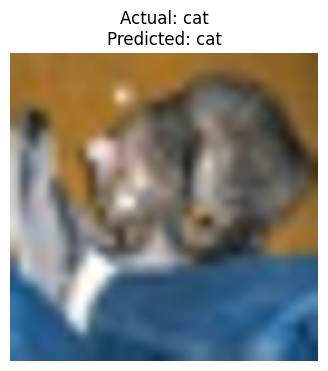

<ipython-input-6-a00fa2f8a7dd>:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  accuracies.append(float(correct_in_top_k.cpu().numpy()))


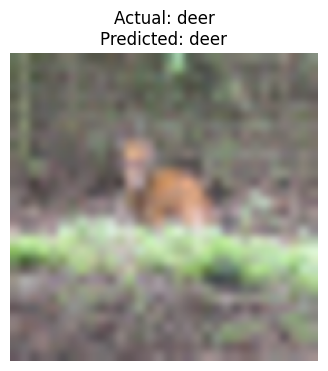

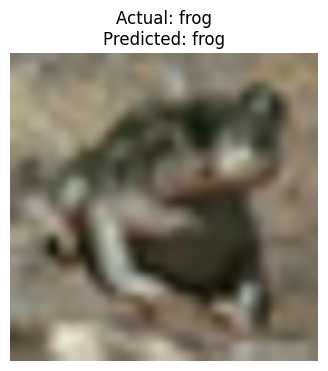

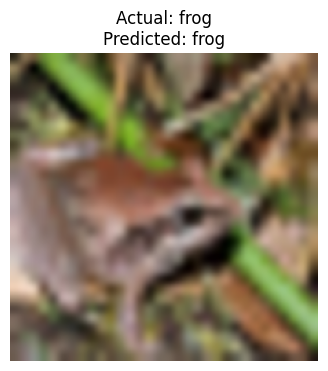

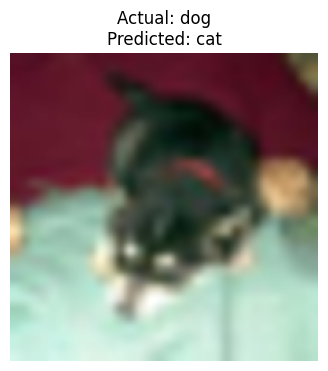

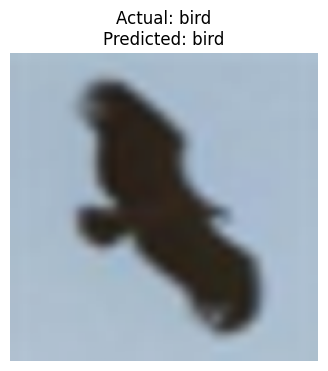

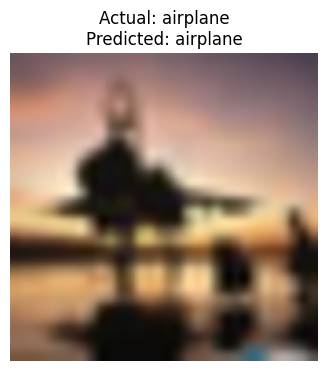

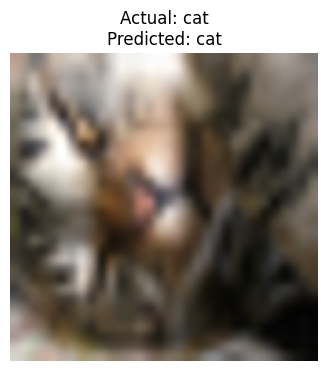

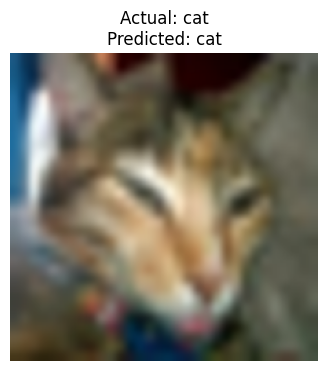

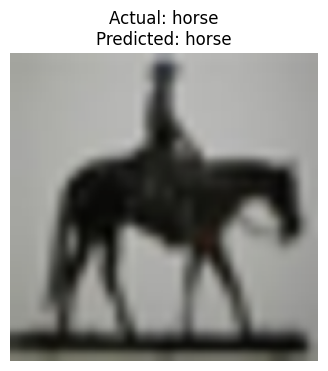

Top-1 accuracy: 89.86
Top-5 accuracy: 99.63


In [8]:
def evaluate_and_visualize_model(model, loader, zeroshot_weights, visualize_predictions, accuracy, cifar10_classes, max_visualizations=10):
    """
    Evaluate and visualize the model's predictions.

    Parameters:
    - model: the model to be evaluated
    - loader: DataLoader for the evaluation dataset
    - zeroshot_weights: the weights used in zero-shot classification
    - visualize_predictions: function to visualize the model's predictions
    - accuracy: function to calculate the accuracy of the model's predictions
    - cifar10_classes: list of class names in CIFAR-10
    - max_visualizations: maximum number of predictions to visualize
    """
    predictions = []
    model.eval()
    with torch.no_grad():
        top1_accuracy, top5_accuracy, total_samples = 0., 0., 0.
        visualization_count = 0

        for batch_index, (image_batch, true_labels) in enumerate(loader):
            # TODO: Send image_batch and true_labels to cuda device
            image_batch, true_labels = image_batch.cuda(), true_labels.cuda()

            # TODO: Generate image features and normalize them
            # HINT: The encode_image() function might be helpful
            image_features = model.encode_image(image_batch)
            image_features /= image_features.norm(dim=-1, keepdim=True)

            # TODO: Calculate the logits
            logits = 100. * image_features @ zeroshot_weights

            _, top_prediction = logits.topk(1, dim=1)

            predictions.append(top_prediction.cpu())

            if visualization_count < max_visualizations:
                visualize_predictions(image_batch, true_labels.cpu(), top_prediction.cpu().squeeze(), cifar10_classes)
                visualization_count += 1

            # Measure and accumulate accuracy
            batch_top1_acc, batch_top5_acc = accuracy(logits, true_labels, topk=(1,5))
            top1_accuracy += batch_top1_acc
            top5_accuracy += batch_top5_acc
            total_samples += image_batch.size(0)

        # Calculate the overall top-1 and top-5 accuracy
        overall_top1_accuracy = (top1_accuracy / total_samples) * 100
        overall_top5_accuracy = (top5_accuracy / total_samples) * 100

        print(f"Top-1 accuracy: {overall_top1_accuracy:.2f}")
        print(f"Top-5 accuracy: {overall_top5_accuracy:.2f}")

        return predictions

predictions = evaluate_and_visualize_model(model, loader, zeroshot_weights, visualize_predictions, accuracy, cifar10_classes)

In [9]:
predictions = torch.cat(predictions).tolist()
import pickle
with open("zero_shot_predictions.pickle", "wb") as file:
    pickle.dump(predictions, file)